In [1]:
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [2]:
batch_size = 84
IMG_SIZE = (160, 160)

In [3]:
data_dir = 'faces'

In [4]:
import numpy as np
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [5]:
from sklearn.preprocessing import LabelEncoder
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [6]:
def create_pairs(x, digit_indices, distinct_labels_length):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(distinct_labels_length)]) - 1
    
    for d in range(distinct_labels_length):
        for i in range(len(digit_indices[d]) - 1):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, distinct_labels_length)
            dn = (d + inc) % distinct_labels_length
            random_index =  random.randrange(1, len(digit_indices[dn]))
            z1, z2 = digit_indices[d][i], digit_indices[dn][random_index]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels, distinct_labels_length):
    
    digit_indices = [np.where(labels == i)[0] for i in range(distinct_labels_length)]
    pairs, y = create_pairs(images, digit_indices, distinct_labels_length)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow((image *255.0).astype("uint8"))
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [7]:
from sklearn.preprocessing import LabelEncoder
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [8]:
images, labels=(trainX, trainy)

In [9]:
print(images.shape)
print(labels.shape)

(93, 160, 160, 3)
(93,)


In [10]:
images = np.array([image for image in images])
images = images / 255.0
print(images.shape)
tr_pairs, tr_y = create_pairs_on_set(images, labels, 5)

(93, 160, 160, 3)


In [11]:
print(tr_pairs.shape)

(176, 2, 160, 160, 3)


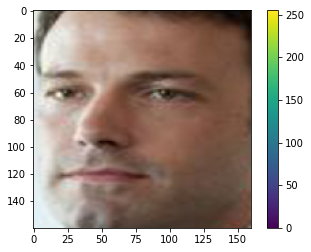

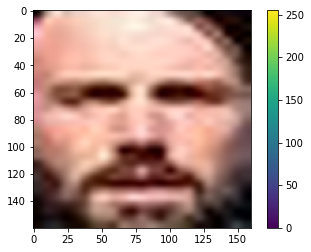

1.0


In [12]:
# array index
this_pair = 8

# show images at this index
show_image(tr_pairs[this_pair][0])
show_image(tr_pairs[this_pair][1])

# print the label for this pair
print(tr_y[this_pair])

In [13]:
images, labels=(testX, testy)

In [14]:
images = np.array([image for image in images])
images = images / 255.0
print(images.shape)
ts_pairs, ts_y = create_pairs_on_set(images, labels,5)

(25, 160, 160, 3)


In [15]:
print(ts_pairs.shape)

(40, 2, 160, 160, 3)


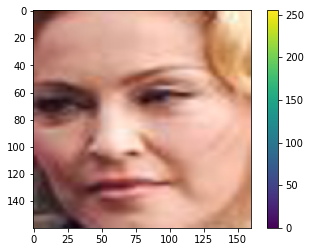

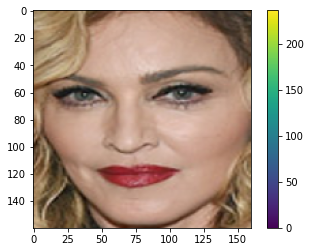

1.0


In [16]:
# array index
this_pair = 28

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

In [17]:
IMG_SHAPE = IMG_SIZE + (3,)
def initialize_base_network():

    base_network = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    input = Input(shape=(160,160,3,), name="base_input")
    x = base_network(input)
    x = Flatten(name="flatten_input")(x)
    #x = Dropout(0.1)(x)
    #x = Dense(2048, activation='relu')(x)
    #x = Dense(128, activation='relu', name="first_base_dense")(x)
    #x = Dropout(0.1, name="first_dropout")(x)
    #x = Dense(256, activation='relu', name="second_base_dense")(x)
    #x = Dropout(0.1, name="second_dropout")(x)
    #x = Dense(512, activation='relu', name="third_base_dense")(x)
    #x = Dropout(0.1, name="third_dropout")(x)
    #x = Dense(512, activation='relu', name="fourth_base_dense")(x)
    #x = Dropout(0.1, name="fourth_dropout")(x)
    #x = Dense(512, activation='relu', name="fifth_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [18]:
# Create the base model from the pre-trained model MobileNet V2
#IMG_SHAPE = IMG_SIZE + (3,)
#base_network = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                               include_top=True,
#                                               weights='imagenet')
base_network = initialize_base_network()

In [19]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [20]:
# create the left input and point to the base network
input_a = Input(shape=IMG_SHAPE, name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=IMG_SHAPE, name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [21]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [22]:
print(np.array([tr_pairs[:,0], tr_pairs[:,1]]).shape)
print(np.array([ts_pairs[:,0], ts_pairs[:,1]]).shape)

(2, 176, 160, 160, 3)
(2, 40, 160, 160, 3)


In [23]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=2000, batch_size=16, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/2000
11/11 [==============================] - 12s 775ms/step - loss: 171.2933 - val_loss: 0.4997
Epoch 2/2000
11/11 [==============================] - 8s 705ms/step - loss: 0.5193 - val_loss: 0.4997
Epoch 3/2000
11/11 [==============================] - 8s 703ms/step - loss: 0.4982 - val_loss: 0.4997
Epoch 4/2000
11/11 [==============================] - 8s 699ms/step - loss: 0.5075 - val_loss: 0.4997
Epoch 5/2000
11/11 [==============================] - 8s 707ms/step - loss: 0.8665 - val_loss: 0.4997
Epoch 6/2000
11/11 [==============================] - 8s 695ms/step - loss: 0.4998 - val_loss: 0.4997
Epoch 7/2000
11/11 [==============================] - 7s 684ms/step - loss: 0.5043 - val_loss: 0.4997
Epoch 8/2000
11/11 [==============================] - 7s 677ms/step - loss: 0.5357 - val_loss: 0.4997
Epoch 9/2000
11/11 [==============================] - 7s 674ms/step - loss: 0.6200 - val_loss: 0.4997
Epoch 10/2000
11/11 [==============================] - 8s 700ms/step - loss: 0.

In [ ]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [ ]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[1:8,0], tr_pairs[1:8,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[1:8,0], ts_pairs[1:8,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

2/2 [==============================] - 0s 8ms/step - loss: 0.2156
Loss = 0.21557681262493134, Train Accuracy = 0.0 Test Accuracy = 0.0


/tmp/ipykernel_5621/2707950740.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.mean(pred == y_true)


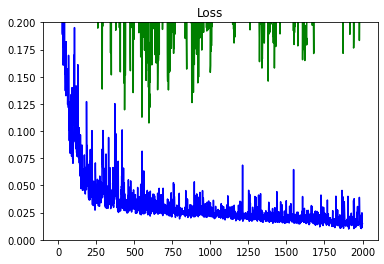

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [ ]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    #left = np.reshape(left, [n, 160,160])
    #left = np.swapaxes(left, 0, 1)
    #left = np.reshape(left, [160,160*n])
    plt.imshow((left *255.0).astype("uint8"))
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    #right = np.reshape(right, [n, 160,160])
    #right = np.swapaxes(right, 0, 1)
    #right = np.reshape(right, [160,160*n])
    plt.imshow((right *255.0).astype("uint8"))

In [ ]:
def print_result(i):
    # array index
    this_pair = i

    # show images at this index
    show_image(ts_pairs[this_pair][0])
    show_image(ts_pairs[this_pair][1])

    # print the label for this pair
    print(ts_y[this_pair])
    print(model.predict([ts_pairs[i:i+1,0], ts_pairs[i:i+1,1]]))

In [ ]:
ts_pairs[2][0].reshape(160,160,3,1).shape

(160, 160, 3, 1)

In [ ]:
left_image = ts_pairs[2][0].reshape(160,160,3,1)
left_image.shape

(160, 160, 3, 1)

In [ ]:
right_image = ts_pairs[2][1].reshape(160,160,3,1)
right_image.shape

(160, 160, 3, 1)

In [ ]:
np.array([tr_pairs[2:3,0], tr_pairs[2:3,1]]).shape

(2, 1, 160, 160, 3)

In [ ]:
print(model.predict([ts_pairs[4:5,0], ts_pairs[2:3,1]]))
print(ts_y[2:3])

[[0.00031623]]
[1.]


In [ ]:
print(model.predict([ts_pairs[5:6,0], ts_pairs[3:4,1]]))
print(ts_y[3:4])

[[1.1675977]]
[0.]


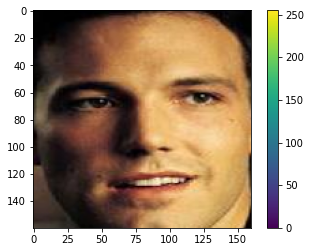

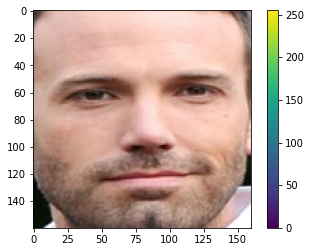

1.0
[[0.3421044]]


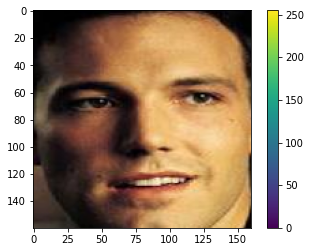

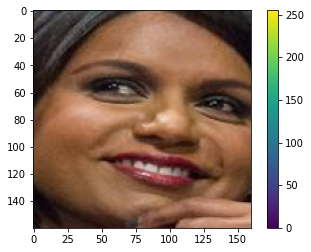

0.0
[[0.3455274]]


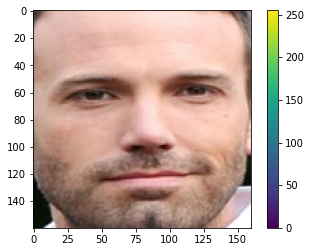

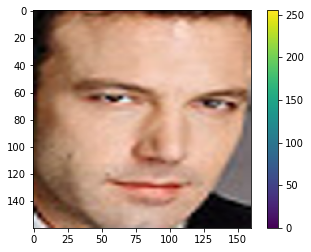

1.0
[[0.68934005]]


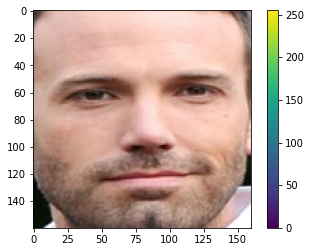

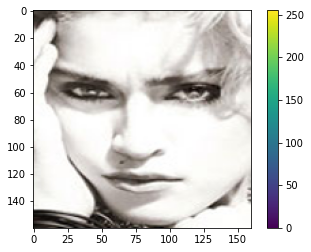

0.0
[[0.9275763]]


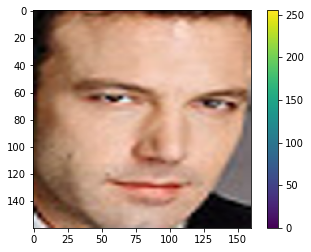

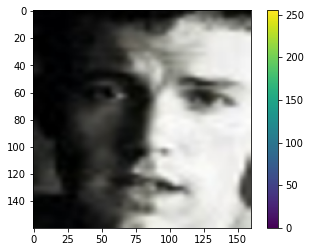

1.0
[[1.1690283]]


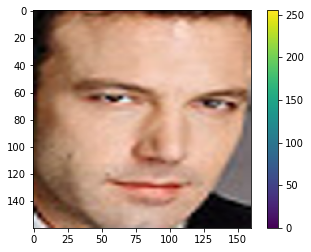

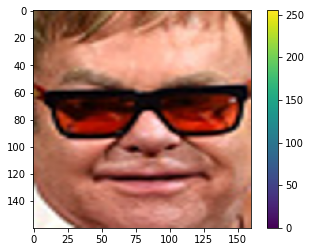

0.0
[[1.1729128]]


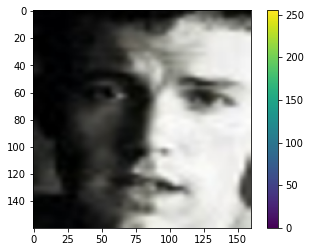

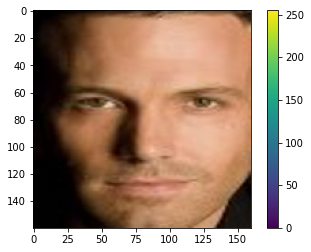

1.0
[[1.163517]]


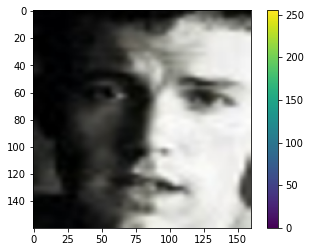

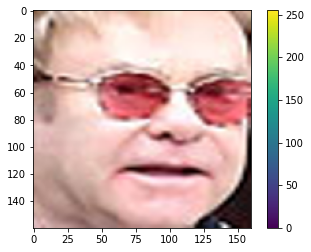

0.0
[[0.00816186]]


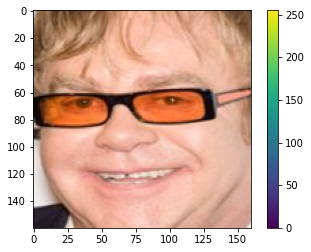

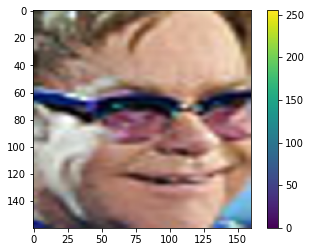

1.0
[[0.02615246]]


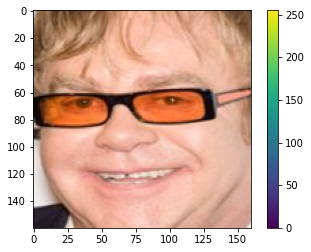

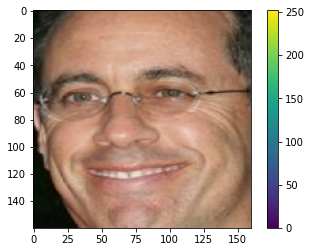

0.0
[[1.1720585]]


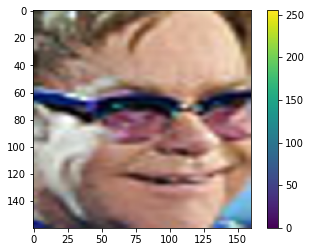

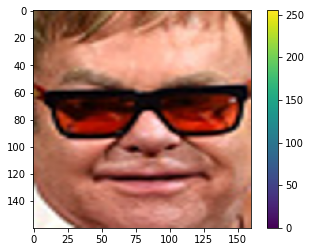

1.0
[[0.03246178]]


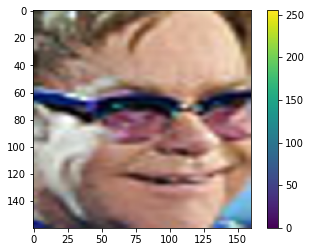

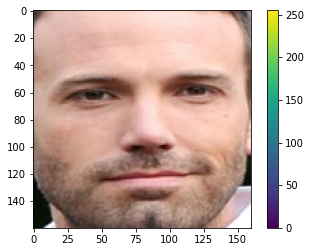

0.0
[[0.94253457]]


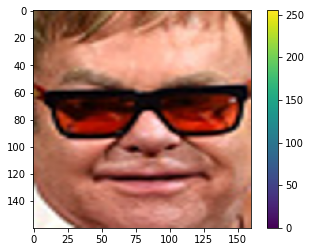

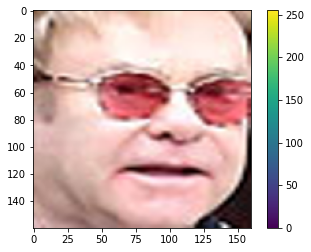

1.0
[[0.00244098]]


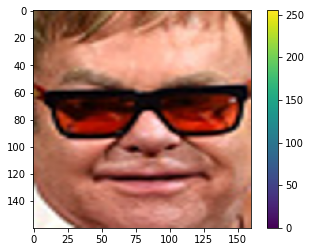

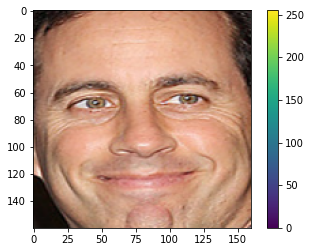

0.0
[[1.17249]]


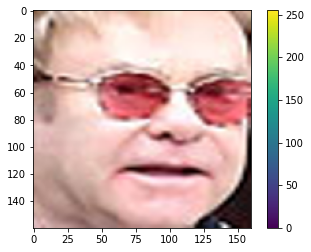

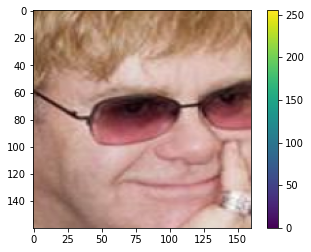

1.0
[[0.03273747]]


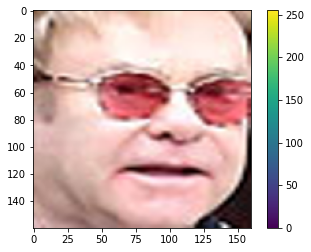

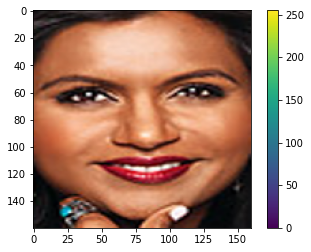

0.0
[[0.964822]]


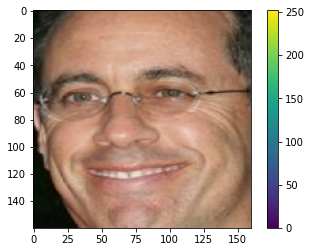

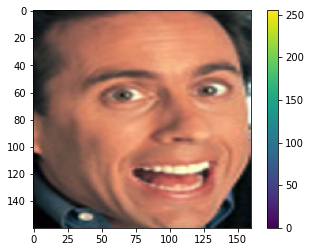

1.0
[[0.36157614]]


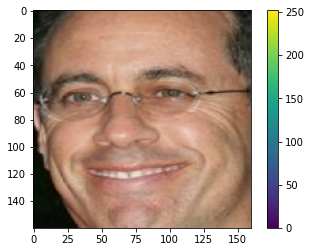

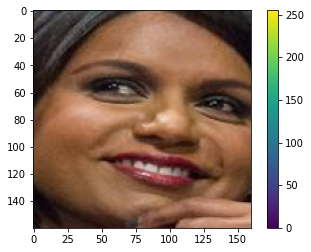

0.0
[[1.4121209]]


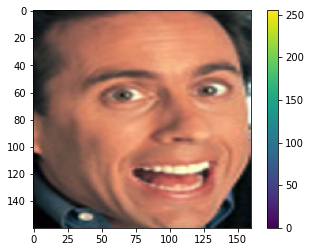

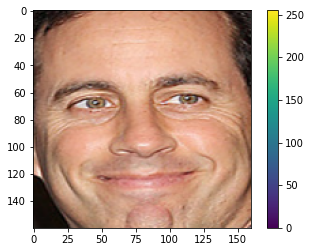

1.0
[[0.36132067]]


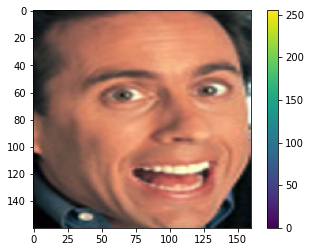

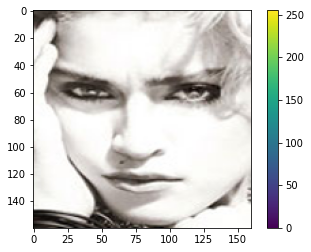

0.0
[[0.9909392]]


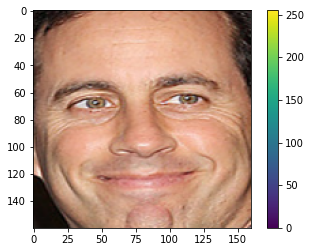

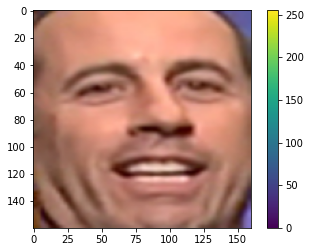

1.0
[[0.00054143]]


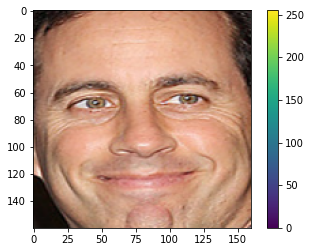

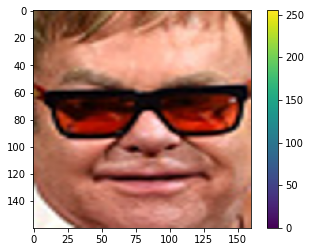

0.0
[[1.17249]]


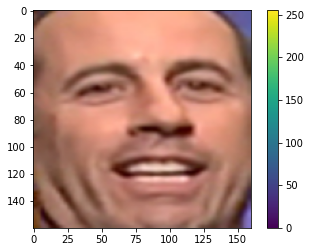

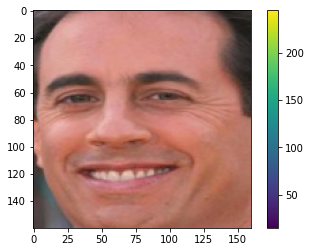

1.0
[[0.56313765]]


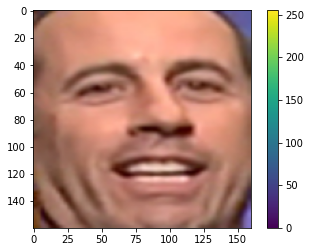

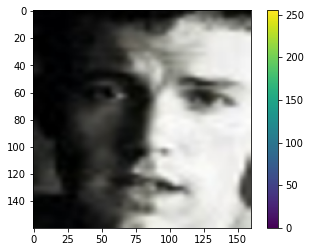

0.0
[[1.169702]]


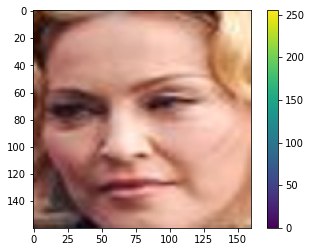

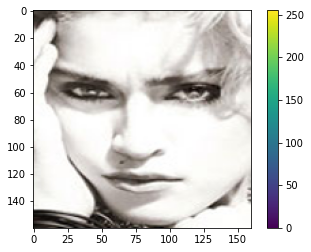

1.0
[[1.10177]]


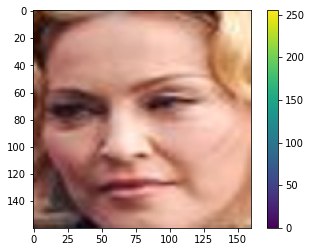

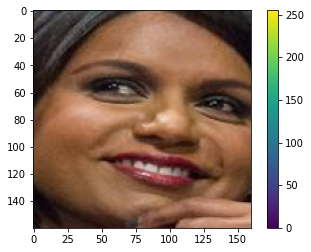

0.0
[[0.11323295]]


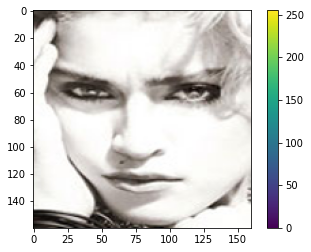

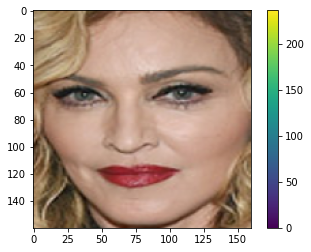

1.0
[[0.09639843]]


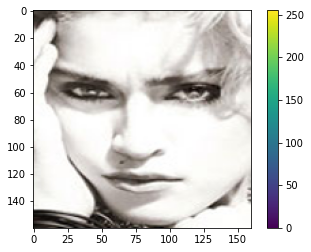

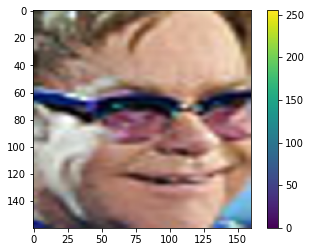

0.0
[[0.0404051]]


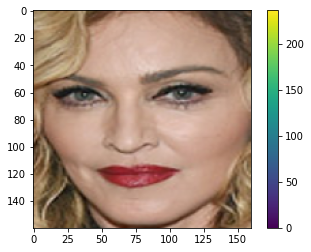

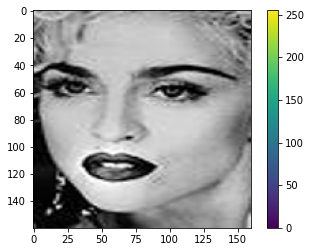

1.0
[[0.09665381]]


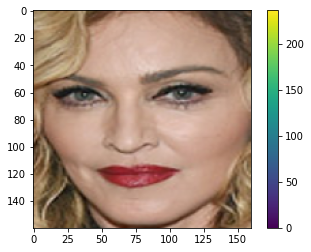

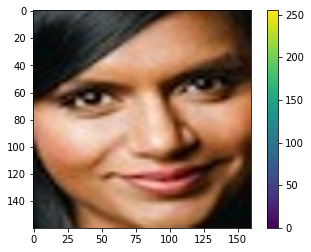

0.0
[[0.94867855]]


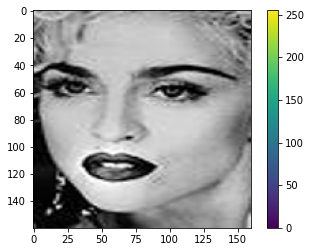

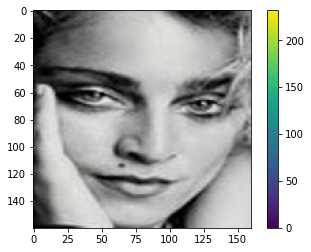

1.0
[[0.02556122]]


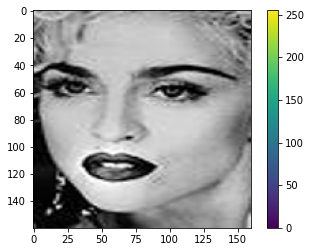

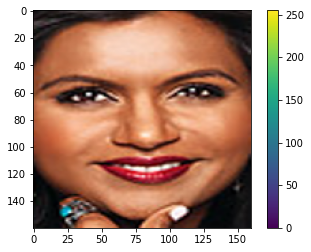

0.0
[[0.9505962]]


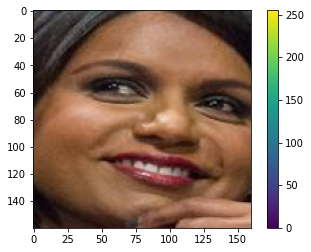

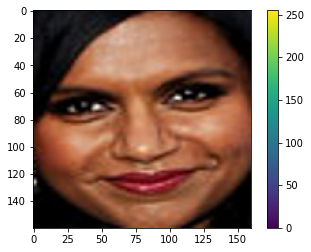

1.0
[[0.17038377]]


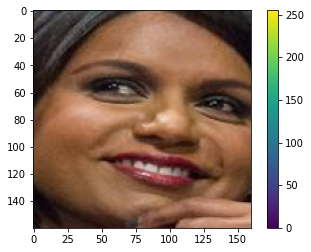

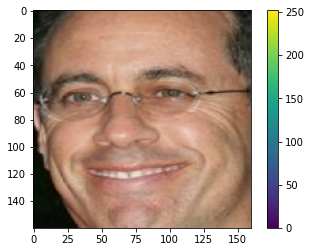

0.0
[[1.4121209]]


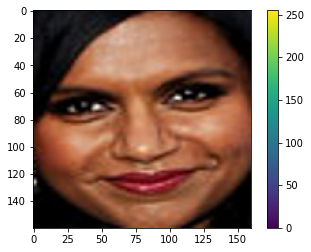

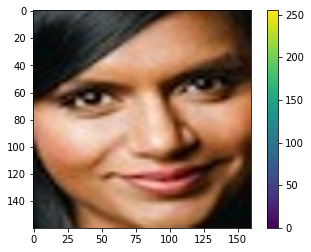

1.0
[[0.31044173]]


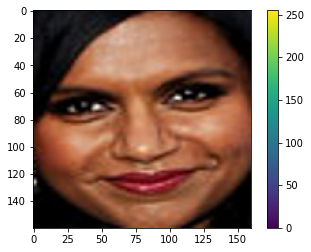

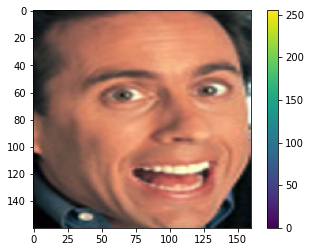

0.0
[[0.8801611]]


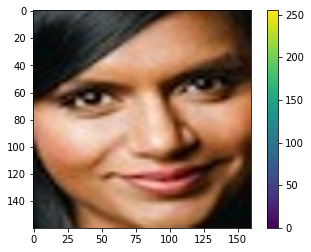

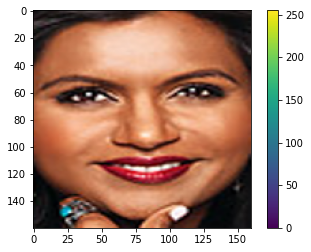

1.0
[[0.01552065]]


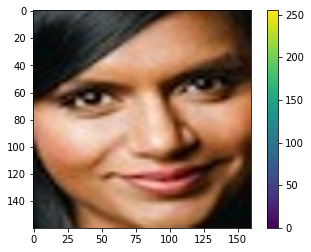

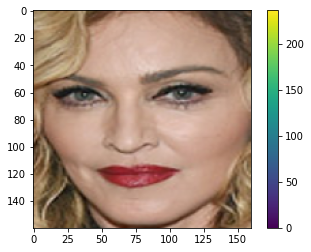

0.0
[[0.94867855]]


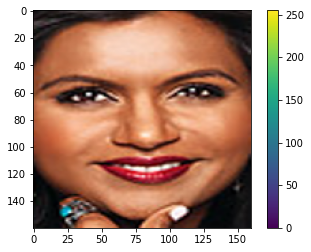

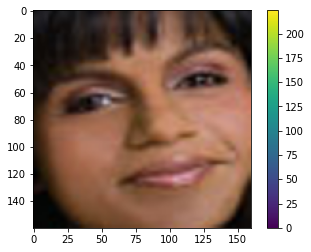

1.0
[[0.46678013]]


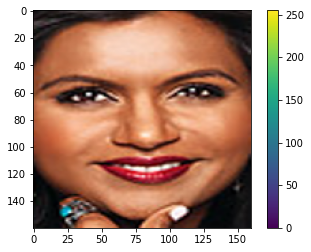

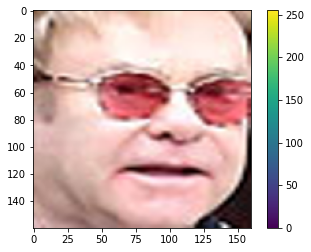

0.0
[[0.964822]]


In [ ]:
for i in range(ts_pairs.shape[0]):
    print_result(i)